In [1]:
import os
import pandas as pd # dataframe library
import tensorflow as tf # neural network library
import numpy as np # quick and efficient math library
import matplotlib.pyplot as plt # plottinng in python library
import plotly.express as px
import random
import shutil

from shutil import copyfile
from sklearn.preprocessing import LabelEncoder # for label encoding
from sklearn.preprocessing import OneHotEncoder # for one hot encoding of labels
from sklearn.model_selection import train_test_split # to split our dataset in training and test set

/Users/tomkirst/Documents/Hochschule/3. Jahr/InnoProjekt/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import os
# ... (andere Imports) ...

# ----------------------------------------------------
# 1. Lokale Pfade definieren (Ersetzt die festen Colab-Pfade)
# ----------------------------------------------------

# Skript liegt in CodeSachen. ".." geht eine Ebene hoch zu "InnoProjekt".
BASE_DIR_OUTPUT = ".." 

# Quellverzeichnisse (Originalbilder)
CAT_DIR = "../DatensatzSachen/PetImages/Cat"
DOG_DIR = "../DatensatzSachen/PetImages/Dog"

# Zielverzeichnisse (Hauptordner)
TRAINING_DIR = os.path.join(BASE_DIR_OUTPUT, "training")
VALIDATION_DIR = os.path.join(BASE_DIR_OUTPUT, "validation")
TESTING_DIR = os.path.join(BASE_DIR_OUTPUT, "testing") # Muss hier definiert werden!

# Zielverzeichnisse (Unterordner für die Klassen)
TRAINING_CATS = os.path.join(TRAINING_DIR, "cats")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats")
TESTING_CATS = os.path.join(TESTING_DIR, "cats") 

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs")
TESTING_DOGS = os.path.join(TESTING_DIR, "dogs") 

INCLUDE_TEST = True 

# ----------------------------------------------------
# 2. Ordnerstruktur erstellen
# ----------------------------------------------------

try:
    # os.makedirs erstellt alle notwendigen Ordner
    os.makedirs(TRAINING_CATS, exist_ok=True)
    os.makedirs(TRAINING_DOGS, exist_ok=True)
    os.makedirs(VALIDATION_CATS, exist_ok=True)
    os.makedirs(VALIDATION_DOGS, exist_ok=True)
    os.makedirs(TESTING_CATS, exist_ok=True)
    os.makedirs(TESTING_DOGS, exist_ok=True)
    
    print("Verzeichnisstruktur erfolgreich lokal erstellt.")

except OSError as e:
    print(f"Fehler beim Erstellen der Verzeichnisse: {e}")

Verzeichnisstruktur erfolgreich lokal erstellt.


In [4]:
# ----------------------------------------------------
# 3. Funktion zum Aufteilen und Kopieren definieren
# ----------------------------------------------------
def split_data(main_dir, training_dir, validation_dir, test_dir, include_test_split=True, split_size=0.9):
    """
    Teilt Dateien aus einem Hauptverzeichnis (main_dir) zufällig in 
    Trainings-, Validierungs- und Testverzeichnisse auf und kopiert sie dorthin.
    """
    files = []
    # 1. Alle Dateinamen sammeln und leere Dateien ignorieren
    for filename in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, filename)) == 0:
            print(f"Datei '{filename}' ist null groß, wird ignoriert.")
        else:
            files.append(filename)

    # 2. Dateien zufällig mischen
    shuffled_files = np.random.permutation(files)
    
    # 3. Splits berechnen
    # 'split' ist der Index, der den Trainingsanteil vom Rest trennt (90%)
    split = int(split_size * len(shuffled_files)) 
    
    # Der Rest (10%) wird weiter in Validierung und Test aufgeteilt (falls include_test_split=True)
    # Wenn Test dabei ist, teilt split_validation_test den Rest in Validation und Test (je 5%)
    split_validation_test = int(split + (len(shuffled_files) - split) / 2)

    train = shuffled_files[:split]
    
    # 4. Validierungs- und Test-Sets zuweisen
    if include_test_split:
        validation = shuffled_files[split:split_validation_test]
        test = shuffled_files[split_validation_test:]
    else:
        # Wenn kein Test-Split gewünscht, geht der gesamte Rest in Validation
        validation = shuffled_files[split:]
        test = [] # Das Test-Set bleibt leer
        
    # 5. Dateien in die Zielordner kopieren
    # Kopieren ins Training-Verzeichnis
    for element in train:
        shutil.copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element))

    # Kopieren ins Validation-Verzeichnis
    for element in validation:
        shutil.copyfile(os.path.join(main_dir, element), os.path.join(validation_dir, element))

    # Kopieren ins Test-Verzeichnis
    if include_test_split:
        for element in test:
            shutil.copyfile(os.path.join(main_dir, element), os.path.join(test_dir, element))
            
    print("Split erfolgreich!")


# ----------------------------------------------------
# 4. Funktion aufrufen und Datentransfer starten
# ----------------------------------------------------
# Aufruf für Katzen
split_data(CAT_DIR, TRAINING_CATS, VALIDATION_CATS, TESTING_CATS, INCLUDE_TEST, split_size=0.9) 
# Aufruf für Hunde
split_data(DOG_DIR, TRAINING_DOGS, VALIDATION_DOGS, TESTING_DOGS, INCLUDE_TEST, split_size=0.9)

Datei '666.jpg' ist null groß, wird ignoriert.
Split erfolgreich!
Datei '11702.jpg' ist null groß, wird ignoriert.
Split erfolgreich!


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter für die Bildverarbeitung
IMAGE_SIZE = (150, 150) # Die Bilder werden auf diese Größe skaliert
BATCH_SIZE = 32         # Wie viele Bilder gleichzeitig verarbeitet werden

# Normalisierung (rescale=1./255): Skaliert Pixelwerte von 0-255 auf 0-1
train_datagen = ImageDataGenerator(rescale=1./255) 
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Trainings-Generator erstellen
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,      # Der Pfad zum Training-Hauptordner
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # Wir haben zwei Klassen (Katze/Hund)
)

# Validierungs-Generator erstellen
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test-Generator erstellen
test_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Für die korrekte Evaluierung wichtig
)

Found 24754 images belonging to 2 classes.
Found 2428 images belonging to 2 classes.
Found 2439 images belonging to 2 classes.


In [6]:
model = tf.keras.models.Sequential([
    # Input ist jetzt 150x150x3 (3 Kanäle für RGB, falls Farbbilder)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Weitere Feature-Extraktionsschichten
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Übergang zur Klassifikation
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Ausgabeschicht: 1 Neuron mit Sigmoid für binäre Klassifikation (Katze vs. Hund)
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

/Users/tomkirst/Documents/Hochschule/3. Jahr/InnoProjekt/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Kompilieren des Modells
model.compile(
    loss='binary_crossentropy', # Binäre Verlustfunktion für zwei Klassen (0 oder 1)
    optimizer='adam',           # Der Standard-Optimierer
    metrics=['accuracy']
)

# Training starten (Dies nutzt Ihren M4 Pro Chip)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Anzahl der Schritte pro Epoche
    epochs=15, # Sie können diese Zahl anpassen
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/Users/tomkirst/Documents/Hochschule/3. Jahr/InnoProjekt/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 69/773 ━━━━━━━━━━━━━━━━━━━━ 1:07 95ms/step - accuracy: 0.5315 - loss: 0.9076

/Users/tomkirst/Documents/Hochschule/3. Jahr/InnoProjekt/venv/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


773/773 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - accuracy: 0.6031 - loss: 0.6887 - val_accuracy: 0.7700 - val_loss: 0.4901
Epoch 2/15
  1/773 ━━━━━━━━━━━━━━━━━━━━ 1:13 95ms/step - accuracy: 0.6875 - loss: 0.4847

/Users/tomkirst/Documents/Hochschule/3. Jahr/InnoProjekt/venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6875 - loss: 0.4847 - val_accuracy: 0.7550 - val_loss: 0.4934
Epoch 3/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - accuracy: 0.7717 - loss: 0.4770 - val_accuracy: 0.8283 - val_loss: 0.3762
Epoch 4/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6250 - loss: 0.6549 - val_accuracy: 0.8317 - val_loss: 0.3672
Epoch 5/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - accuracy: 0.8362 - loss: 0.3667 - val_accuracy: 0.8875 - val_loss: 0.2727
Epoch 6/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8750 - loss: 0.3033 - val_accuracy: 0.8842 - val_loss: 0.2760
Epoch 7/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 367s 475ms/step - accuracy: 0.8900 - loss: 0.2563 - val_accuracy: 0.9171 - val_loss: 0.2098
Epoch 8/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7500 - loss: 0.4189 - val_accuracy: 0.9179 - val_loss: 0.2136
Epoch 9/15
773/773 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - accuracy: 0.9533 - loss: 0.1227 - val_accuracy: 0

In [8]:
# ----------------------------------------------------
# 1. Leistung des Modells auf Testdaten messen
# ----------------------------------------------------
print("--- Modell-Evaluierung auf ungesehenen Testdaten ---")
loss, accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)

print(f"\nTest-Loss: {loss:.4f}")
print(f"Test-Genauigkeit (Accuracy): {accuracy*100:.2f}%")

--- Modell-Evaluierung auf ungesehenen Testdaten ---
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9658 - loss: 0.1532

Test-Loss: 0.1181
Test-Genauigkeit (Accuracy): 97.37%


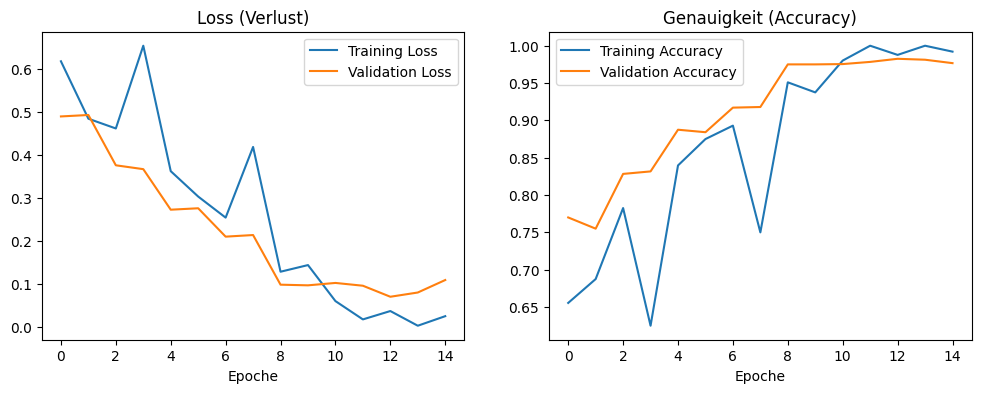

In [9]:
# ----------------------------------------------------
# 2. Lernkurve plotten
# ----------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot für Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Verlust)')
plt.xlabel('Epoche')
plt.legend()

# Plot für Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Genauigkeit (Accuracy)')
plt.xlabel('Epoche')
plt.legend()

plt.show()

In [10]:
import tensorflow as tf
import numpy as np

# ⚠️ HIER PFAD ZU IHREM NEUEN BILD EINFÜGEN ⚠️
# Beispiel: neuer_pfad = "/Users/IhrName/Bilder/neue_katze.jpg"
neuer_pfad = "/Users/tomkirst/Documents/Hochschule/3. Jahr/InnoProjekt/Katzenbild.jpg" 
IMAGE_SIZE = (150, 150)

# Bild laden und auf 150x150 skalieren
img = tf.keras.utils.load_img(neuer_pfad, target_size=IMAGE_SIZE)

# Bild in ein Array konvertieren
img_array = tf.keras.utils.img_to_array(img)

# Dimension hinzufügen, um das Modell-Input-Format (1, 150, 150, 3) zu erreichen
# Das Modell erwartet eine Batch-Größe (die 1 am Anfang)
img_array = np.expand_dims(img_array, axis=0)

# Normalisieren (Teilen durch 255.0, wie bei den Trainingsdaten)
img_array = img_array / 255.0

print("Bild erfolgreich geladen und vorverarbeitet.")

Bild erfolgreich geladen und vorverarbeitet.


In [11]:
# Vorhersage treffen
prediction = model.predict(img_array)

# Das Ergebnis ist eine Wahrscheinlichkeit
probability = prediction[0][0]

# Interpretation (Wenn das Modell mit class_mode='binary' trainiert wurde):
# Ein Wert nahe 0 bedeutet die erste Klasse (Katze), ein Wert nahe 1 die zweite Klasse (Hund)
# Da der Trainings-Generator 'cats' vor 'dogs' findet:
# 0 = Cat / 1 = Dog

if probability < 0.5:
    result_class = "Katze"
    confidence = 1 - probability
else:
    result_class = "Hund"
    confidence = probability

# Ausgabe der Ergebnisse
print("\n--- Vorhersage des CNN ---")
print(f"Wahrscheinlichkeit (Ziffer 1): {probability:.4f}")
print(f"Das Modell sagt voraus: {result_class}")
print(f"Zuversicht: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

--- Vorhersage des CNN ---
Wahrscheinlichkeit (Ziffer 1): 0.0000
Das Modell sagt voraus: Katze
Zuversicht: 100.00%
